# Lookahead Optimizer _ k steps forward _ 1 step backward

## 0. Paper

### Info
* TItle : Lookahead Optimizer _ k steps forward _ 1 step backward
* Author : Michael R Zhang et al.
* Link : https://arxiv.org/pdf/1907.08610.pdf

### Summary
* k step의 fast weight를 활용하여 slow weight 업데이트
* 하이퍼파라미터에 안정적인 최적화 가능

### Differences
* Model : ResNet -> CNN

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'epoch_size' : 30
}

## 2. Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

## 3. Model

In [199]:
class LookaheadOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, alpha=0.5, k=5, name='LookaheadOptimizer', **kwargs):
        super().__init__(name, **kwargs)
        self.alpha = alpha # outer learning rate
        self.k = k # inner step size
        self.inner_optimizer = tf.keras.optimizers.Adam(1e-3)

    def _create_slots(self, var_list):
        self.inner_optimizer._create_slots(var_list)
        for var in var_list:
            self.add_slot(var, 'slow weight')

    @tf.function
    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        local_step = tf.cast(self.iterations + 1, var_dtype)
        self.inner_optimizer.iterations.assign(self.iterations)

        slow_weight = self.get_slot(var, 'slow weight')
        if local_step == 1:
            slow_weight.assign(var)

        self.inner_optimizer._resource_apply_dense(grad, var)
        if local_step % self.k == 0:
            new_slow_weight = slow_weight + self.alpha * (var - slow_weight)
            var.assign(new_slow_weight)
            slow_weight.assign(new_slow_weight)
    
    @tf.function
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        config = super().get_config()
        config.update({
            'alpha' : self.alpha,
            'k' : self.k
        })
        return config

In [191]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, 5, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, 5, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, 5, activation='relu')
        self.pool = tf.keras.layers.MaxPool2D(3, strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1000, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## 4. Train

In [206]:
lookahead = LookaheadOptimizer()
lookahead_model = Model()
lookahead_model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = lookahead
)

In [ ]:
lookahead_hist = lookahead_model.fit(x_train, y_train, batch_size=CONFIG['batch_size'], epochs=10)

In [208]:
adam_model = Model()
adam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = 'adam'
)

In [ ]:
adam_hist = adam_model.fit(x_train, y_train, batch_size=CONFIG['batch_size'], epochs=10)

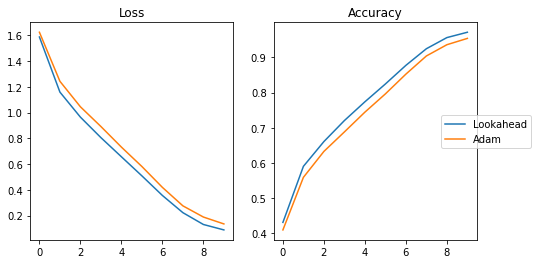

In [210]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(lookahead_hist.history['loss'])
ax[0].plot(adam_hist.history['loss'])
ax[0].set_title('Loss')

ax[1].plot(lookahead_hist.history['acc'])
ax[1].plot(adam_hist.history['acc'])
ax[1].set_title('Accuracy')

fig.legend(['Lookahead', 'Adam'], loc='right')
plt.show()